In [1]:
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

import pyomo.opt as po
import pyomo.environ as pe

init_notebook_mode(connected=True)

## Input Data

In [2]:
#Unit sell price in dollars.
sell_price = {
    'Economy': 0.99,
    'Deluxe': 1.75
}

#Department labor capcity in hours.
dept_capacity = {
    'Preprocessing': 12,
    'Curing': 8.25,
    'Shaping': 13,
    'Assembly': 18
}

#Department load data for every unit of product.  Converting time unit from seconds to hours.
dept_unit_load = {
    ('Preprocessing', 'Economy'): 2.0/3600, ('Preprocessing', 'Deluxe'): 2.0/3600, 
    ('Curing', 'Economy'): 3.5/3600, ('Curing', 'Deluxe'): 3.5/3600,
    ('Shaping', 'Economy'): 1.25/3600, ('Shaping', 'Deluxe'): 8.75/3600,
    ('Assembly', 'Economy'): 8.0/3600, ('Assembly', 'Deluxe'): 10.0/3600
}

#Bill of Material (BOM) data.  Converting unit of ounces to pounds on items described by weight.
unit_bom = {
    ('Cedar Blank', 'Economy'): 0.1, ('Cedar Blank', 'Deluxe'): 0.1,
    ('Glue', 'Economy'): 1.5/16, ('Glue', 'Deluxe'): 1.5/16,
    ('Basic Lead', 'Economy'): 3/16, ('Basic Lead', 'Deluxe'): 0/16,
    ('Smooth Lead', 'Economy'): 0/16, ('Smooth Lead', 'Deluxe'): 3.5/16,
    ('Matte Paint', 'Economy'): 2.8/16, ('Matte Paint', 'Deluxe'): 0/16,
    ('Wood Stain', 'Economy'): 0/16, ('Wood Stain', 'Deluxe'): 2.5/16,
    ('Ferrule', 'Economy'): 1, ('Ferrule', 'Deluxe'): 1,
    ('Eraser', 'Economy'): 1, ('Eraser', 'Deluxe'): 1,
    ('Grip', 'Economy'): 0, ('Grip', 'Deluxe'): 1
}

#Part costs in dollars.
part_cost = {
    'Cedar Blank': 0.15,
    'Glue': 0.75,
    'Basic Lead': 0.45,
    'Smooth Lead': 0.64,
    'Matte Paint': 0.57,
    'Wood Stain': 0.89,
    'Ferrule': 0.10,
    'Eraser': 0.05,
    'Grip': 0.13
}

#Part inventory
part_inv = {
    'Cedar Blank': 15000,
    'Glue': 1250,
    'Basic Lead': 950,
    'Smooth Lead': 1750,
    'Matte Paint': 840,
    'Wood Stain': 1100,
    'Ferrule': 10000,
    'Eraser': 32000,
    'Grip': 20000
}

labor_rate = 0.65*60 #unit: dollars/hour

## Development of Profit Contribution Values

In [3]:
matl_cost = {}
for prod in ['Economy', 'Deluxe']:
    m_cost = 0
    for part in part_cost.keys():
        m_cost += part_cost[part]*unit_bom[(part, prod)]
    matl_cost[prod] =m_cost
matl_cost

{'Economy': 0.41943749999999996, 'Deluxe': 0.644375}

In [4]:
labor_cost = {}
for prod in ['Economy', 'Deluxe']:
    l_time = 0
    for dept in dept_capacity.keys():
        l_time += dept_unit_load[(dept, prod)]
    labor_cost[prod] = l_time*labor_rate
labor_cost

{'Economy': 0.1597916666666667, 'Deluxe': 0.2627083333333333}

In [5]:
profit_contrib = {}
for prod in ['Economy', 'Deluxe']:
    profit_contrib[prod] = sell_price[prod] - matl_cost[prod] - labor_cost[prod]
profit_contrib

{'Economy': 0.4107708333333334, 'Deluxe': 0.8429166666666665}

## Model Definition

- Decision variables shall represent the quantity of each product to produce.  Let the quantity of Economy Writer pencils and the quantity of Deluxe Writer pencil be $x_e$ and $x_d$, respectively.
- The objective function should maximize the total profit contribution.
- Constraints will be needed to acknowledge the limited number of labor hours in each department and the fixed amount of inventory for each component.

Linear programming model is shown below.

$$ \text{max } 0.39x_e + 0.76x_d$$
$$ \text{s.t.} $$
$\text{The following 4 constraints represent labor consumption in each department.  Time units are in hours.}$
$$ (5.56 \cdot 10^{-4})x_e + (5.56 \cdot 10^{-4})x_d \le 12 $$
$$ (9.72 \cdot 10^{-4})x_e + (9.72 \cdot 10^{-4})x_d \le 6.25 $$
$$ (3.47 \cdot 10^{-4})x_e + (2.43 \cdot 10^{-3})x_d \le 8 $$
$$ (2.78 \cdot 10^{-3})x_e + (5.00 \cdot 10^{-3})x_d \le 10 $$
$\text{The following constraints prevent the model from violating any inventory limits.}$
$$ 0.1x_e + 0.1x_d \le 15,000 $$
$$ 0.092x_e + 0.094x_d \le 1,250 $$
$$ 0.188x_e \le 950 $$
$$ 0.219x_d \le 800 $$
$$ 0.175x_e \le 500 $$
$$ 0.156x_d \le 300 $$
$$ x_e + x_d \le 10,000 $$
$$ x_e + x_d \le 32,000 $$
$$ x_d \le 20,000 $$
$\text{Nonnegativity constraints on decision variables.}$
$$x_d, x_e \ge 0 $$

The above description of the model is specific to the given characteristics of the problem.  If the amount of a component used in a product or the unit labor time in a department changed, then it would need to be updated.  Typically it is more convenient to describe the model using sets and variables.  This generally results in a more concise and robust description.  An example of this is shown below.

*Sets*  
Let A be the set of products.  
Let D be the set of departments.  
Let C be the set of parts/components.

*Parameters*  
Let $p_a$ be the unit profit contribution of product a.  
Let $b_{a,d}$ be the unit labor demand for product a in department d.  
Let $t_d$ be the labor capacity in department d.  
Let $m_{c,a}$ be the amount of part c consumed when building one unit of product a.  
Let $n_c$ be the amount of inventory of part c.  

*Decision Variables*  
Let $x_a$ represent the quantity to produce for each product a.

*LP Model*  

$$ \text{max } \sum_{a \in A} p_ax_a $$
$$ \text{s.t.} $$
$$ \sum_{a \in A} b_{a,d}x_a \le t_d \hspace{5mm} \forall d \in D $$
$$ \sum_{a \in A} m_{c,a}x_a \le n_c  \hspace{5mm} \forall c \in C $$
$$ x_a \ge 0 \hspace{5mm} \forall a \in A $$

## Software Solution

### Pyomo Model Development

In [6]:
model = pe.ConcreteModel(name='Pencil Production')

In [7]:
model.x_econ = pe.Var(domain = pe.NonNegativeReals)
model.x_del = pe.Var(domain = pe.NonNegativeReals)

#### Objective Function

In [8]:
obj_expr = model.x_econ*profit_contrib['Economy'] + model.x_del*profit_contrib['Deluxe']
model.obj = pe.Objective(sense = pe.maximize, expr=obj_expr)

#### Labor Capacity Constraints

In [9]:
model.preproc = pe.Constraint(expr = model.x_econ*dept_unit_load[('Preprocessing', 'Economy')] + model.x_del*dept_unit_load[('Preprocessing', 'Deluxe')] <= dept_capacity['Preprocessing'])
model.curing = pe.Constraint(expr = model.x_econ*dept_unit_load[('Curing', 'Economy')] + model.x_del*dept_unit_load[('Curing', 'Deluxe')] <= dept_capacity['Curing'])
model.shaping = pe.Constraint(expr = model.x_econ*dept_unit_load[('Shaping', 'Economy')] + model.x_del*dept_unit_load[('Shaping', 'Deluxe')] <= dept_capacity['Shaping'])
model.asbly = pe.Constraint(expr =  model.x_econ*dept_unit_load[('Assembly', 'Economy')] + model.x_del*dept_unit_load[('Assembly', 'Deluxe')] <= dept_capacity['Assembly'])

#### Component Inventory Constraints

In [10]:
model.blank = pe.Constraint(expr = model.x_econ*unit_bom[('Cedar Blank', 'Economy')] + model.x_del*unit_bom[('Cedar Blank', 'Deluxe')] <= part_inv['Cedar Blank'])
model.glue = pe.Constraint(expr = model.x_econ*unit_bom[('Glue', 'Economy')] + model.x_del*unit_bom[('Glue', 'Deluxe')] <= part_inv['Glue'])
model.basic_lead = pe.Constraint(expr = model.x_econ*unit_bom[('Basic Lead', 'Economy')] + model.x_del*unit_bom[('Basic Lead', 'Deluxe')] <= part_inv['Basic Lead'])
model.smooth_lead = pe.Constraint(expr = model.x_econ*unit_bom[('Smooth Lead', 'Economy')] + model.x_del*unit_bom[('Smooth Lead', 'Deluxe')] <= part_inv['Smooth Lead'])
model.matte_paint = pe.Constraint(expr = model.x_econ*unit_bom[('Matte Paint', 'Economy')] + model.x_del*unit_bom[('Matte Paint', 'Deluxe')] <= part_inv['Matte Paint'])
model.wood_stain = pe.Constraint(expr = model.x_econ*unit_bom[('Wood Stain', 'Economy')] + model.x_del*unit_bom[('Wood Stain', 'Deluxe')] <= part_inv['Wood Stain'])
model.ferrule = pe.Constraint(expr = model.x_econ*unit_bom[('Ferrule', 'Economy')] + model.x_del*unit_bom[('Ferrule', 'Deluxe')] <= part_inv['Ferrule'])
model.eraser = pe.Constraint(expr = model.x_econ*unit_bom[('Eraser', 'Economy')] + model.x_del*unit_bom[('Eraser', 'Deluxe')] <= part_inv['Eraser'])
model.grip = pe.Constraint(expr = model.x_econ*unit_bom[('Grip', 'Economy')] + model.x_del*unit_bom[('Grip', 'Deluxe')] <= part_inv['Grip'])

### Solving Pyomo Model

In [11]:
solver = po.SolverFactory('glpk')
result = solver.solve(model, tee=True)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\brock\AppData\Local\Temp\tmpz9bxyg_1.glpk.raw --wglp C:\Users\brock\AppData\Local\Temp\tmppz8107v9.glpk.glp
 --cpxlp C:\Users\brock\AppData\Local\Temp\tmp_vmvfm5i.pyomo.lp
Reading problem data from 'C:\Users\brock\AppData\Local\Temp\tmp_vmvfm5i.pyomo.lp'...
14 rows, 3 columns, 22 non-zeros
76 lines were read
Writing problem data to 'C:\Users\brock\AppData\Local\Temp\tmppz8107v9.glpk.glp'...
58 lines were written
GLPK Simplex Optimizer, v4.65
14 rows, 3 columns, 22 non-zeros
Preprocessing...
4 rows, 2 columns, 8 non-zeros
Scaling...
 A: min|aij| =  3.472e-04  max|aij| =  1.000e+00  ratio =  2.880e+03
GM: min|aij| =  6.148e-01  max|aij| =  1.627e+00  ratio =  2.646e+00
EQ: min|aij| =  3.780e-01  max|aij| =  1.000e+00  ratio =  2.646e+00
Constructing initial basis...
Size of triangular part is 4
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (2)
*     3: obj =   5.008314130e+03 inf =   0.00

### Inspecting Solved Pyomo Model

In [12]:
model.display()

Model Pencil Production

  Variables:
    x_econ : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 1721.73913043478 :  None : False : False : NonNegativeReals
    x_del : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 5102.60869565217 :  None : False : False : NonNegativeReals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 5008.314130434778

  Constraints:
    preproc : Size=1
        Key  : Lower : Body               : Upper
        None :  None : 3.7913043478260833 :  12.0
    curing : Size=1
        Key  : Lower : Body              : Upper
        None :  None : 6.634782608695645 :  8.25
    shaping : Size=1
        Key  : Lower : Body               : Upper
        None :  None : 12.999999999999991 :  13.0
    asbly : Size=1
        Key  : Lower : Body               : Upper
        None 

In [13]:
print("**Optimal Production Plan**")
print(f"Qty. Economy Writer Pencils: {pe.value(model.x_econ):,.1f}")
print(f"Qty. Deluxe Writer Pencils: {pe.value(model.x_del):,.1f}")
print(f"Resulting Profit Contribution: ${pe.value(model.obj):,.2f}")

**Optimal Production Plan**
Qty. Economy Writer Pencils: 1,721.7
Qty. Deluxe Writer Pencils: 5,102.6
Resulting Profit Contribution: $5,008.31


In [14]:
print(f'Slack of Preprocessing Dept: {model.preproc.uslack():,.2f} hours')
print(f'Slack of Curing Dept: {model.curing.uslack():,.2f} hours')
print(f'Slack of Shaping Dept: {model.shaping.uslack():,.2f} hours')
print(f'Slack of Assembly Dept: {model.asbly.uslack():,.2f} hours')

Slack of Preprocessing Dept: 8.21 hours
Slack of Curing Dept: 1.62 hours
Slack of Shaping Dept: 0.00 hours
Slack of Assembly Dept: 0.00 hours


In [15]:
print(f'Slack of Cedar Blanks: {model.blank.uslack():,.2f}')
print(f'Slack of Basic Lead: {model.basic_lead.uslack():,.2f} lb.')
print(f'Slack of Smooth Lead: {model.smooth_lead.uslack():,.2f} lb.')
print(f'Slack of Matte Paint: {model.matte_paint.uslack():,.2f} lb.')
print(f'Slack of Wood Stain: {model.wood_stain.uslack():,.2f} lb.')
print(f'Slack of Ferrule: {model.ferrule.uslack():,.2f}')
print(f'Slack of Eraser: {model.eraser.uslack():,.2f}')
print(f'Slack of Grip: {model.grip.uslack():,.2f}')

Slack of Cedar Blanks: 14,317.57
Slack of Basic Lead: 627.17 lb.
Slack of Smooth Lead: 633.80 lb.
Slack of Matte Paint: 538.70 lb.
Slack of Wood Stain: 302.72 lb.
Slack of Ferrule: 3,175.65
Slack of Eraser: 25,175.65
Slack of Grip: 14,897.39


## Graphical Solution

The LP model described below contains only 2 decision variables. Hence, a graphical approach can also be implemented to achieve the optimal solution.

### Feasible Region Definition

In [16]:
def preprocess_trace():
    x_e = np.arange(0, 12*3600/2, 10)
    x_d = (3600/2)*(12 -(2/3600)*x_e)
    return go.Scatter(
        x=x_e,
        y=x_d,
        name='Preprocessing Dept.',
        fill='tozeroy'
    )

def curing_trace():
    x_e = np.arange(0, 8.25*3600/3.5, 10)
    x_d = (3600/3.5)*(8.25-(3.5/3600)*x_e)
    return go.Scatter(
        x=x_e,
        y=x_d,
        name='Curing Dept.',
        fill='tozeroy'
    )

def shaping_trace():
    x_e = np.arange(0, 13*3600/1.25, 10)
    x_d = (3600/8.75)*(13 - (1.25/3600)*x_e)
    return go.Scatter(
        x=x_e, 
        y=x_d,
        name='Shaping Dept.', 
        fill='tozeroy'
    )

def asbly_trace():
    x_e = np.arange(0, 18*3600/8, 10)
    x_d = (3600/10)*(18 - (8/3600)*x_e)
    return go.Scatter(
        x=x_e,
        y=x_d,
        name='Assembly Dept.',
        fill='tozeroy'
    )

def blank_trace():
    x_e = np.arange(0, 15000/0.1, 10)
    x_d = (1/0.1)*(15000-0.1*x_e)
    return go.Scatter(x=x_e, y=x_d, name='Cedar Blanks', fill='tozeroy')

def glue_trace():
    x_e = np.arange(0,1250/(1.5/16), 10)
    x_d = (16/1.5)*(1250-(1.5/16)*x_e)
    return go.Scatter(x=x_e, y=x_d, name='Glue', fill='tozeroy')

def basic_lead_trace():
    x_d = np.arange(0,150000,1000)
    x_e = np.ones_like(x_d)*950/(3.0/16)
    return go.Scatter(x=x_e, y=x_d, name='Basic Lead', fill='tozerox')

def smooth_lead_trace():
    x_e = np.arange(0,150000,1000)
    x_d = np.ones_like(x_e)*1750/(3.5/16)
    return go.Scatter(x=x_e, y=x_d, name='Smooth Lead', fill='tozeroy')

def paint_trace():
    x_d = np.arange(0,150000,1000)
    x_e = np.ones_like(x_d)*840/(2.8/16) 
    return go.Scatter(x=x_e, y=x_d, name='Matte Paint', fill='tozerox')

def stain_trace():
    x_e = np.arange(0,150000,1000)
    x_d = np.ones_like(x_e)*1100/(2.5/16)
    return go.Scatter(x=x_e, y=x_d, name='Wood Stain', fill='tozeroy')

def ferrule_trace():
    x_e = np.arange(0,10000,100)
    x_d = 10000 - x_e
    return go.Scatter(x=x_e, y=x_d, name='Ferrule', fill='tozerox')

def eraser_trace():
    x_e = np.arange(0,32000,100)
    x_d = 32000 - x_e
    return go.Scatter(x=x_e, y=x_d, name='Eraser', fill='tozerox')

def grip_trace():
    x_e = np.arange(0,150000,1000)
    x_d = np.ones_like(x_e)*20000
    return go.Scatter(x=x_e, y=x_d, name='Grip', fill='tozeroy')
    
dept_labor_traces = [preprocess_trace(), curing_trace(), shaping_trace(), asbly_trace()]
bom_traces = [blank_trace(), glue_trace(), basic_lead_trace(), smooth_lead_trace(), paint_trace(), stain_trace(), ferrule_trace(), eraser_trace(), grip_trace()]
constraint_traces = dept_labor_traces + bom_traces

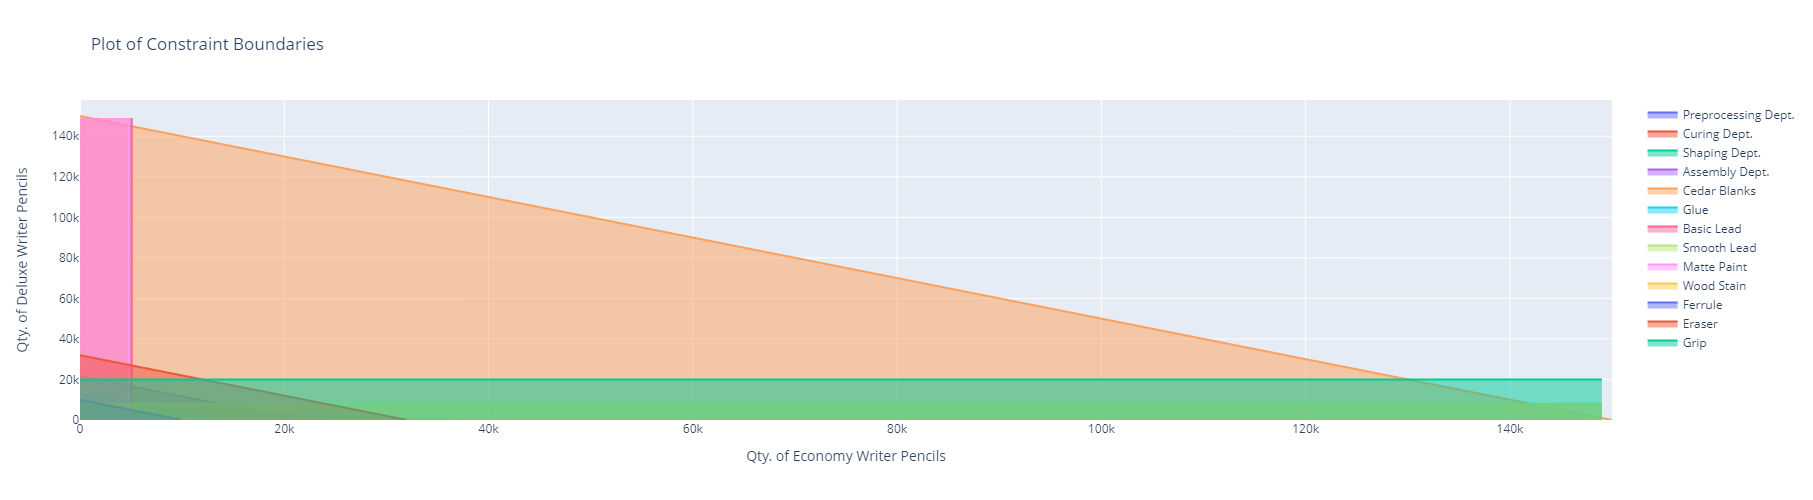

In [17]:
layout = {'height': 500, 
         'xaxis': {'title': 'Qty. of Economy Writer Pencils'},
         'yaxis': {'title': 'Qty. of Deluxe Writer Pencils'},
          'title': {'text': 'Plot of Constraint Boundaries'}
         }
fig = go.Figure(data=constraint_traces, layout=layout)
iplot(fig)

The graphical method requires that the common intersection of all constraint regions must be identified.  This common region contains the set of feasible points which satisfies all the constraints.  In this problem most of the constraints won't play a part in forming this region.  Inspection should lead to identifying that the shaping department, assembly department and matte paint constaints along with the axes define the feasible region.

In [18]:
a = np.array([[1.25/3600, 8.75/3600], [8/3600, 10/3600]])
b = np.array([13, 18])
shaping_asbly_intercept = np.linalg.solve(a,b)
print(f"Intersection of shaping and assembly department constraints: ({shaping_asbly_intercept[0]:,.1f}, {shaping_asbly_intercept[1]:,.1f})")

Intersection of shaping and assembly department constraints: (1,721.7, 5,102.6)


In [19]:
shaping_deluxe_intercept = 13*3600/8.75
paint_economy_intercept = 840/(2.8/16)

paint_asbly_intercept_deluxe_coord = (3600/10)*(18 - (8/3600)*paint_economy_intercept)
print(f"Intersection of assembly department and matte paint constraints: ({paint_economy_intercept:,.1f}, {paint_asbly_intercept_deluxe_coord:,.1f})")

Intersection of assembly department and matte paint constraints: (4,800.0, 2,640.0)


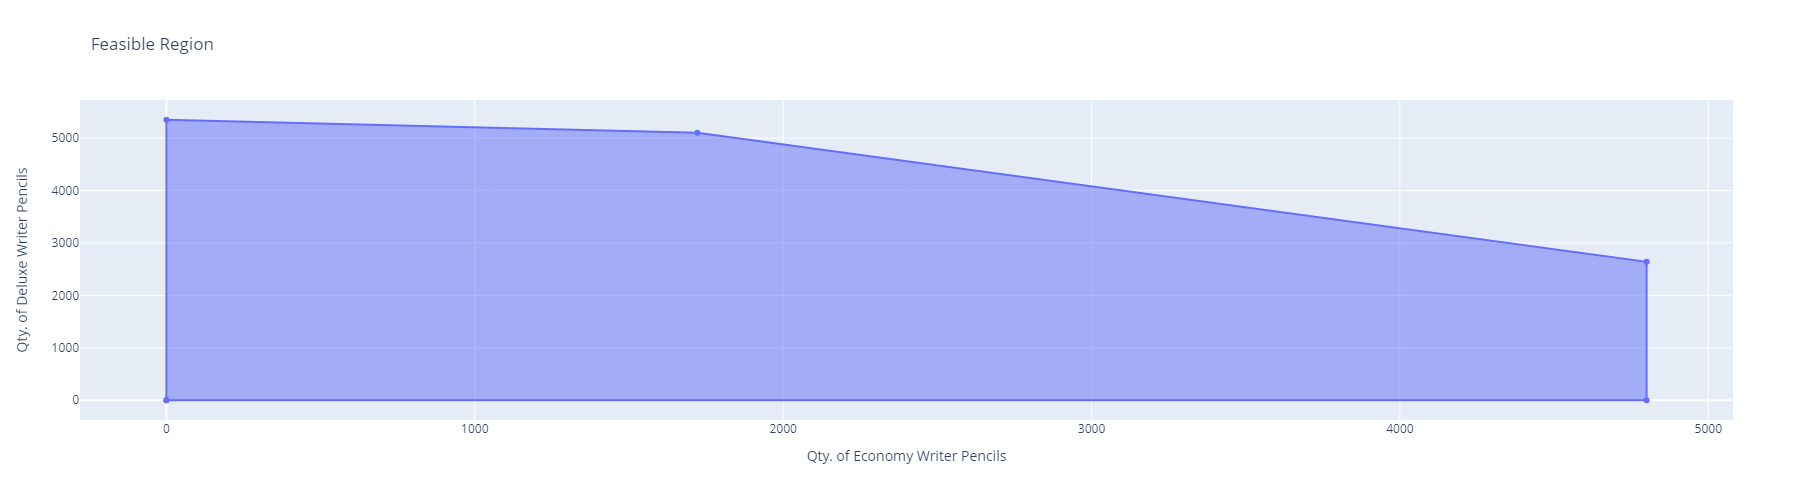

In [20]:
feasible_region = go.Scatter(
    x = [0,0,shaping_asbly_intercept[0], paint_economy_intercept, paint_economy_intercept,0],
    y = [0,shaping_deluxe_intercept,shaping_asbly_intercept[1], paint_asbly_intercept_deluxe_coord, 0,0],
    fill = 'toself',
    name ='Feasible Region'
)

layout['title']['text'] = 'Feasible Region'

fig = go.Figure(data=[feasible_region], layout=layout)
iplot(fig)

### Optimal Solution Investigation

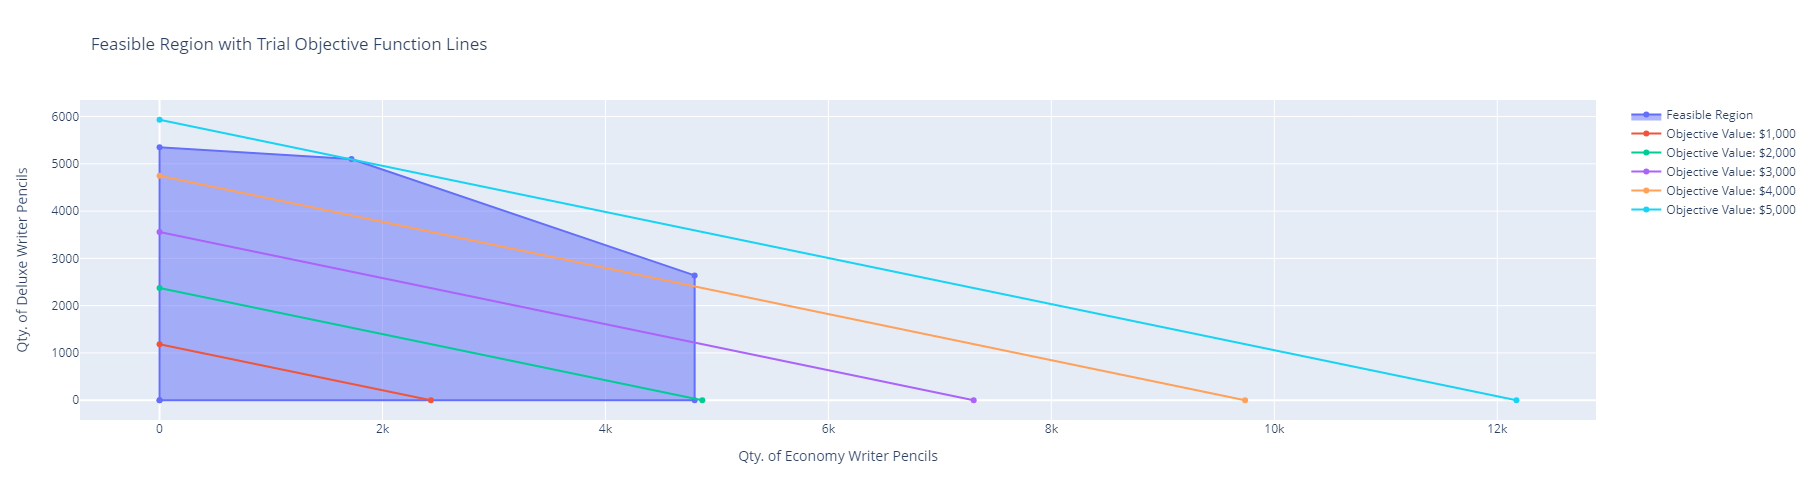

In [21]:
obj_traces = []
for i in [1000, 2000, 3000, 4000, 5000]:
    obj_traces.append(go.Scatter(
        x = [0, i/profit_contrib['Economy']],
        y = [i/profit_contrib['Deluxe'], 0],
        name = f'Objective Value: ${i:,}'
    ))
    
layout['title']['text'] = 'Feasible Region with Trial Objective Function Lines'
fig = go.Figure(data=[feasible_region]+obj_traces, layout=layout)
iplot(fig)

Inspecting the above figure reveals that the optimal solution will be at the intersection of the boundaries formed by the shaping and assembly departments.  This results in an objective value of slightly more than $5,000.  A more exact statement of the optimal solution is provided below.

In [22]:
print(f"**Optimal Solution**")
print(f"Quantity of Economy Writer Pencils: {shaping_asbly_intercept[0]:,.1f}")
print(f"Quantity of Deluxe Writer Pencils: {shaping_asbly_intercept[1]:,.1f}")
print(f"Profit Contribution: ${shaping_asbly_intercept[0]*profit_contrib['Economy'] + shaping_asbly_intercept[1]*profit_contrib['Deluxe']:,.2f}")

**Optimal Solution**
Quantity of Economy Writer Pencils: 1,721.7
Quantity of Deluxe Writer Pencils: 5,102.6
Profit Contribution: $5,008.31


### Optimal Solution Review

The above solutions consider the decision variables to be continous real numbers.  This presents a bit of a problem for the application under consideration as pencils can't be continously divided and sold.  Instead they are discrete and only integer values are possible.  This leads to a discussion of a programming problems where the integer requirement is inforced on the decision variables.  This is a bit beyond the scope of the present discussion.  

To remedy the current problem, one can observe that all the constraints are less than or equal.  Hence, we can round down the quantity of each product to produce and be sure not to violate any constraints.  This solution will be a very good solution, although we can't be guaranteed that it is the optimal integer solution without further study.